## Проект: надо научить модель различать по описанию товара, названии объявления, цене, категории, региона, города и по дате, есть ли у пользователя номер телефона, как отдельная ячейка или нет(колонка is_bad). Кстати, train на 80 процентов размечен не правильно, а valid только на 10 процентов

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.pyplot import hist
import string
from nltk.corpus import stopwords
sw_ru = set(stopwords.words('russian'))
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score

#### Датасет с сайта авито. Таргет: есть ли номер телефона у пользователя как отдельная ячейка (is_bad). 

In [2]:
df = pd.read_csv("train_avito.csv")
df.tail()

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
984482,Штампы 61r,+79780979761/\nДенис/\nширину обода и вылет на...,Запчасти и аксессуары,Транспорт,2000.0,Крым,Мирное,2019-10-09 23:55:54.099019,1
984483,Juul,Зарядка и под в комплекте.,Коллекционирование,Хобби и отдых,1200.0,Россия,Москва,2019-10-09 23:56:13.283059,0
984484,Белый стул IKEA,Белый стул Ikea /\nСостояние требует ремонта: ...,Мебель и интерьер,Для дома и дачи,500.0,Россия,Санкт-Петербург,2019-10-09 23:58:42.377241,0
984485,"5-к квартира, 32 м², 2/2 эт.",Бронирование с октября по январь 1010 г./\n ...,Квартиры,Недвижимость,800.0,Калининградская область,Калининград,2019-10-09 23:59:26.744680,0
984486,"Репетитор по математике, подготовка к огэ",Основное и самое любимое направление моей рабо...,Предложение услуг,Услуги,1300.0,Московская область,Балашиха,2019-10-09 23:59:41.342367,1


#### Проблема в том что некоторые номера содержаться в описании, в таком случае is_bad = 1. Надо узнать содержаться ли номера в описаниях. Многие номера написаны неоодназначным способом. К примеру: 8-701-..., 8701... или 8 701 ... и т.д. 

#### К тому же датасет содержит не правильную разметку таргетов, а валидационные данные содержат правильную разметку
#### Сначала решим проблему с неправильной разметкой

In [3]:
df.shape

(984487, 9)

#### Проанализурем баланс между двумя классами

In [4]:
# Датасет несбалансирован
print(f'доля класса 1 = {df.is_bad.value_counts()[1] / df.shape[0]}')
print(f'доля класса 0 = {df.is_bad.value_counts()[0] / df.shape[0]}')

доля класса 1 = 0.24202046344949196
доля класса 0 = 0.757979536550508


In [5]:
# Кол-во уникальных городов
df.city.nunique()

3311

In [6]:
# Кол-во уникальных субкатегорий
df.subcategory.nunique()

50

In [7]:
# Посмотрим, как вообще выглядат описание товаров
df.iloc[3].description

'Продам телевизор . Диагональ 450.наличие входа USB для подключения накопителей и специализированных многофункциональных устройств;/\n/\nфункция приема сигнала сети Интернет;/\n/\nвозможность останавливать трансляцию ТВ-программ при помощи Time Shift;/\n/\nтехнология Quattron, улучшающая цветопередачу экрана;/\n/\nсканирующая подсветка, не допускающая смазывания кадров;/\n/\nимеющаяся  функция Skype Ready;/\n/\nкомплектование жидкокристаллическими панелями последнего поколения X-gen;/\n/\nсистема Aquos.'

In [8]:
# Уникальные значения категорий
df.category.unique()

array(['Для дома и дачи', 'Транспорт', 'Услуги', 'Бытовая электроника',
       'Хобби и отдых', 'Личные вещи', 'Недвижимость', 'Животные',
       'Для бизнеса', 'Работа'], dtype=object)

#### Проблему с разметкой решаем таким образом: обучаем на валидационных данных и предиктим на тренировочных

In [9]:
# Cчитываю валидационные данные
val = pd.read_csv("val.csv")

#### Для начала проанализируем valid

In [10]:
val.iloc[2].description

'Шины зимние б/у Marshal Assimetric I”Zen KW 61 681/41 r 63 диски AVA  литые универсальные 4 J 63 3/600 или 3/663,2 ЕТ 28~31. Забрать можно на Ярославском шоссе у МКАД или в г. Сергиев Посад. Могу подвезти(по договорённости) Состояние- на 6~5 сезона. БЕЗ ТОРГА и. 8 964 688 36 68'

In [11]:
val.iloc[1].description

'Мобильная перегородка, предназначена для разграничения пространства в арендуемых помещениях.Отлично подойдет под ремонт мобильной техники, ремонт часов, обуви и др.услуг. Перегородку можно собрать прямо или под углом 90 градусов, угол можно сделать в любом месте.Длина 1500 высота 6500'

In [12]:
val.drop({'datetime_submitted'}, axis = 1, inplace= True)

In [13]:
val.iloc[6].description

'Продам авто в хорошем состоянии.все вопросы по тел.Двигатель стоит родной,611л/с ,самый надёжный в этой линейке.Салон фестфалия-трансформер,очень редкая комплектация:диван раскладывается и получаеться двухспальная кровать,выдвижной столик,монитор,люк,электро жабры,электро стеклоподъемники,электро зеркала с подогревом,кожаный салон,передняя подушка безопасности,потолок алькантара,кондиционер,вебаста с таймером,очень удобно зимой.ABS,ESP,ASR,блокировка передних колёс (W),Теперь из не достатков:присутствует не большая коррозия в углу на правом пороге,притертость не значительная на сдвижной двери.От машины не избавляюсь,езжу каждый день,так что перекупам и стоянки просьба не беспокоить.Торг приветствуется,в подарок отдам зимнюю резину на литых дисках.звоните 8 девятьсот девятнадцать694 тридцать четыре 29 .'

In [14]:
val[val.is_bad == 1].description

0                                      Звонить 89425546881
2        Шины зимние б/у Marshal Assimetric I”Zen KW 61...
6        Продам авто в хорошем состоянии.все вопросы по...
10       toyo observe g5-ice   без грыж и порезов звони...
14       Продаётся 5 комнатная квартира, косметический ...
                               ...                        
16223    Продаётся участок 8,1 соток,с хозпостройкой, в...
16224    заводится очень долго стоит продаю от ненужнос...
16225    Минимойка Xiaomi Kärcher K1 FM Cordless/\n /\n...
16228    Продается Луидор 33 года. Вместе с работой, во...
16236    Машина технически в отличном состояние все сис...
Name: description, Length: 3981, dtype: object

In [23]:
val.head(2)

,title,description,subcategory,category,price,region,city,is_bad
0,Шины,Звонить 89425546881,Запчасти и аксессуары,Транспорт,2000.0,Тульская область,Огаревка,1
1,Продается мобильная перегородка с дверью,"Мобильная перегородка, предназначена для разгр...",Оборудование для бизнеса,Для бизнеса,10500.0,Вологодская область,Вологда,0


In [24]:
val.subcategory.nunique()

50

In [25]:
val.category.nunique()

10

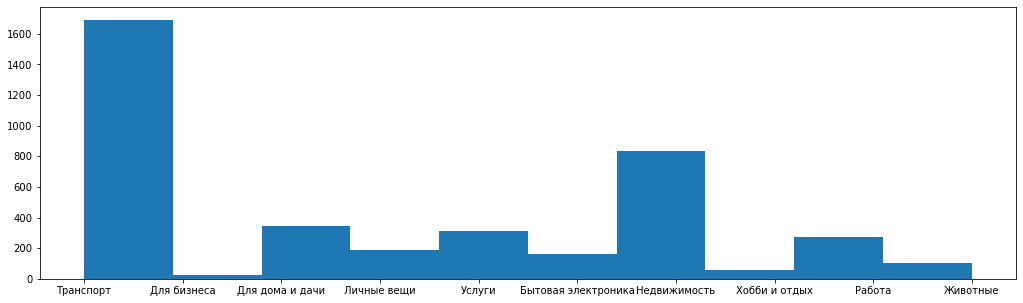

In [26]:
# Посмотрим баланс 0 и 1 для каждой категории в valid
fig = plt.figure()
fig.set_size_inches(17.5, 5)
plt.hist(val.category, weights = val.is_bad)
plt.show()

In [30]:
# Посмотрим какие субкатегории содержатся в категориях
for i in val.category.unique():
    print(f'{i} категории: {val[val.category == i].subcategory.unique()}', end = '\n')
    print()

Транспорт категории: ['Запчасти и аксессуары' 'Мотоциклы и мототехника' 'Автомобили'
 'Грузовики и спецтехника' 'Водный транспорт']

Для бизнеса категории: ['Оборудование для бизнеса' 'Готовый бизнес']

Для дома и дачи категории: ['Мебель и интерьер' 'Ремонт и строительство' 'Растения'
 'Продукты питания' 'Бытовая техника' 'Посуда и товары для кухни']

Личные вещи категории: ['Красота и здоровье' 'Одежда, обувь, аксессуары' 'Детская одежда и обувь'
 'Часы и украшения' 'Товары для детей и игрушки']

Услуги категории: ['Предложение услуг']

Бытовая электроника категории: ['Настольные компьютеры' 'Товары для компьютера' 'Фототехника' 'Телефоны'
 'Аудио и видео' 'Оргтехника и расходники' 'Игры, приставки и программы'
 'Планшеты и электронные книги' 'Ноутбуки']

Недвижимость категории: ['Квартиры' 'Земельные участки' 'Коммерческая недвижимость'
 'Дома, дачи, коттеджи' 'Комнаты' 'Гаражи и машиноместа'
 'Недвижимость за рубежом']

Хобби и отдых категории: ['Спорт и отдых' 'Охота и рыбалка' 'К

In [31]:
val.subcategory

0            Запчасти и аксессуары
1         Оборудование для бизнеса
2            Запчасти и аксессуары
3                Мебель и интерьер
4          Мотоциклы и мототехника
                   ...            
16232    Коммерческая недвижимость
16233                     Телефоны
16234                     Квартиры
16235                     Квартиры
16236                   Автомобили
Name: subcategory, Length: 16237, dtype: object

In [33]:
val.corr().style.background_gradient(cmap='coolwarm')

,price,is_bad
price,1.000000,0.015870
is_bad,0.015870,1.000000


#### После анализа, можно сказать, что не один из фичей кроме description не является информативной для is_bad. Фича description является полезной, так как она содержит номера пользователей. Если в описании есть номер, то скорее всего у него не будет отдельной ячейки для номера телефона. Следовательно, из фичей берем только description, остальные фичи являются не особо информативными для таргета

In [4]:
val = pd.read_csv("val.csv")

In [5]:
val.head()

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
0,Шины,Звонить 89425546881,Запчасти и аксессуары,Транспорт,2000.0,Тульская область,Огаревка,2019-10-10 00:00:25.200714,1
1,Продается мобильная перегородка с дверью,"Мобильная перегородка, предназначена для разгр...",Оборудование для бизнеса,Для бизнеса,10500.0,Вологодская область,Вологда,2019-10-10 00:03:11.527292,0
2,Комплект зимних шин на дисках 682/32/64,Шины зимние б/у Marshal Assimetric I”Zen KW 61...,Запчасти и аксессуары,Транспорт,4000.0,Россия,Москва,2019-10-10 00:05:07.193248,1
3,Кровать-трансормер Дакота сб-4085,"Продаю кровать-трансформер производства ""Столп...",Мебель и интерьер,Для дома и дачи,17000.0,Московская область,Химки,2019-10-10 00:05:58.165179,0
4,Honda VFR 800 2004 г.в,"Мот в отличном состоянии для своих лет, Родной...",Мотоциклы и мототехника,Транспорт,235000.0,Брянская область,Брянск,2019-10-10 00:06:19.231151,0


#### Есть такая проблема: в описании люди пишут номера либо через дефис, либо через пробел или букву и т.д. Чтобы обойти эту проблему, используем всевозможные пары слов. Это, по крайней мере, будет хоть как-то информативно для модели(содержит ли данное описание номер телефона или нет)

#### Берем всевозможные пары символов.

In [6]:
d = {}
# Разумеется, для начала уберем знаки препинания
# Данная функция проверяет содержание пар в каждом описании датасета. 
# Я решил взять пару всех английский и русских букв, + все цифры и пробел
def preprocessing(text):
    text = text.lower()
    for i in string.punctuation:
        if i in text:
            text = text.replace(i, "")
    
    clean_text = ' '.join([word for word in text.split() if not word in sw_ru])
    for i in clean_text:
        if (i >= 'a' and i <= 'z') or (i >= 'а' and i <= 'я') or (i >= '0' and i <= '9') or (i == ' '):
            d[i] = i
    return text

val.description = val.description.apply(preprocessing)

In [7]:
arr = sorted(d)

In [8]:
for i in arr:
    for j in arr:
        lst = []
        if i != j:
            for text in val.description:
                if text.find(i) >= 0 and text.find(j) >= 0:
                    lst.append(1)

                else:
                    lst.append(0)
            string = sorted(i + j)
            string = ''.join(string)
            val[string] = lst

C:\Users\F330~1\AppData\Local\Temp/ipykernel_17992/1178207721.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  val[string] = lst


In [9]:
val.drop({'title', 'description', 'subcategory', 'category', 'price', 'region', 'city'}, axis = 1, inplace=True)
val.drop({'datetime_submitted'}, axis = 1, inplace=True)

In [10]:
y = val.is_bad
X = val.drop({'is_bad'}, axis = 1)

#### Датасет содержащий частоту появлений символов в каждом описании.

In [11]:
X

,0,1,2,3,4,5,6,7,8,9,...,ыь,ыэ,ыю,ыя,ьэ,ью,ья,эю,эя,юя
0,0,1,1,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,1,1,0,0,1,...,1,0,1,1,0,1,1,0,0,1
2,1,1,1,1,1,1,1,0,1,1,...,1,0,0,1,0,0,1,0,0,0
3,1,1,0,0,1,1,0,0,1,1,...,1,0,1,1,0,1,1,0,0,1
4,1,0,0,1,1,0,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16232,1,1,1,1,1,1,1,0,1,0,...,1,1,1,1,1,1,1,1,1,1
16233,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
16234,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,0,1,1,0,0,1
16235,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [12]:
# Without Cross - validation
lr = LogisticRegression(random_state=17)
lr.fit(X, y)
y_pred = lr.predict(X)
print(f'accuracy = {accuracy_score(y_pred, y)}')
print(f'recall = {recall_score(y_pred, y)}')
print(f'precision = {precision_score(y_pred, y)}')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy = 0.8662314466958182
recall = 0.7699194270367055
precision = 0.6480783722682742


In [19]:
X['is_bad'] = y

#### Теперь проведем ту же процедуру для train датасета и запредиктим на ней, чтобы исправить ее разметки

In [17]:
d = {}
df.description = df.description.apply(preprocessing)
arr = sorted(d)

In [23]:
for i in arr:
    for j in arr:
        lst = []
        if i != j:
            for text in df.description:
                if text.find(i) >= 0 and text.find(j) >= 0:
                    lst.append(1)

                else:
                    lst.append(0)
            string = sorted(i + j)
            string = ''.join(string)
            df[string] = lst
            
df.drop({'title', 'subcategory', 'category', 'price', 'region', 'city', 'datetime_submitted'}, axis = 1, inplace =True)
df

C:\Users\F330~1\AppData\Local\Temp/ipykernel_15476/1833759493.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[string] = lst


In [4]:
X1 = df.drop({'is_bad', 'description'}, axis = 1)

In [3]:
X1.head()

,0,1,2,3,4,5,6,7,8,9,...,ыь,ыэ,ыю,ыя,ьэ,ью,ья,эю,эя,юя
0,1,0,1,0,1,0,1,0,0,0,...,1,0,1,1,0,1,1,0,0,1
1,1,0,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1
3,1,0,0,0,1,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
y_pred_fixed = lr.predict(X1)

In [15]:
len(y_pred_fixed)

984487

In [16]:
X1['is_bad'] = y_pred_fixed

In [17]:
X1

,0,1,2,3,4,5,6,7,8,9,...,ыэ,ыю,ыя,ьэ,ью,ья,эю,эя,юя,is_bad
0,1,0,1,0,1,0,1,0,0,0,...,0,1,1,0,1,1,0,0,1,0
1,1,0,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,1,0
2,1,1,1,1,1,1,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1
3,1,0,0,0,1,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
984482,1,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
984483,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
984484,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,0,0,1,0
984485,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


In [22]:
df = X1.append(X, ignore_index=True)

In [24]:
df

,0,1,2,3,4,5,6,7,8,9,...,ыэ,ыю,ыя,ьэ,ью,ья,эю,эя,юя,is_bad
0,1,0,1,0,1,0,1,0,0,0,...,0,1,1,0,1,1,0,0,1,0
1,1,0,1,1,1,0,1,0,1,1,...,1,1,1,1,1,1,1,1,1,0
2,1,1,1,1,1,1,0,1,0,0,...,1,1,1,1,1,1,1,1,1,1
3,1,0,0,0,1,1,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000719,1,1,1,1,1,1,1,0,1,0,...,1,1,1,1,1,1,1,1,1,0
1000720,1,1,1,1,1,1,0,1,1,1,...,1,1,1,1,1,1,1,1,1,0
1000721,1,1,1,1,1,1,1,1,1,1,...,0,1,1,0,1,1,0,0,1,0
1000722,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,0


In [ ]:
df.to_csv('fixed_train.csv', index = False)

In [3]:
df = pd.read_csv("fixed_train.csv")

In [5]:
X = df.drop({'is_bad'}, axis = 1)
y = df.is_bad
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=17)
lr = LogisticRegression(random_state=17, n_jobs=-1)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_train)

#### Мой компьютер не смог обучить окончательную модель, так как тренировочный датасет содержал слишком много данных